In [1]:
# Cell 1: Install required libraries
!pip install torch transformers pandas accelerate bitsandbytes sentencepiece datasets tqdm


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 36.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 17.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 27.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 790.2 kB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 6.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 14.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 6.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 85.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 76.1/76.1 MB 10.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 487.4/487.4 kB 39.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

In [2]:
# Cell 2: Import libraries
import pandas as pd
import torch
import numpy as np
from transformers import AutoTokenizer, AutoModelForCausalLM, BitsAndBytesConfig
from tqdm.auto import tqdm
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import os
import gc
import time

In [3]:
# Cell 3: Load and explore the dataset
df = pd.read_csv('/content/merged_tweets.csv')
print("Dataset shape:", df.shape)
print("\nColumn names:", df.columns.tolist())
print("\nSample data:")
display(df.head())
# Distribution of labels
print("\nLabel distribution:")
print(df['label'].value_counts())


Dataset shape: (5250, 5)

Column names: ['Tweet ID', 'Text', 'Languages', 'CMI', 'label']

Sample data:


,Tweet ID,Text,Languages,CMI,label
0,866871160725794816,Triple Talaq par ...,en hi hi hi hi hi hi,14.29,NO
1,880356789358743553,Batao ye uss ...,hi hi hi en hi hi hi en hi en hi hi hi hi hi h...,19.05,YES
2,877751493889105920,Hindu baheno par ...,hi hi hi hi hi hi hi rest hi hi hi hi hi hi hi...,5.00,NO
3,901806457871466496,Naa bhai .. ...,hi hi rest hi hi hi rest hi en hi hi hi hi hi ...,18.52,NO
4,866264330748219392,#RememberingRajiv aaj agar ...,rest hi hi hi hi en hi hi hi hi hi hi hi hi hi...,20.00,NO



Label distribution:
label
NO     4746
YES     504
Name: count, dtype: int64


In [4]:
# Cell 4: Preprocess the data
# Clean the text column if needed
df['Text'] = df['Text'].astype(str).str.strip()

# Create feature and target variables
X = df['Text'].values
y = (df['label'] == 'YES').astype(int)  # Convert to binary (0 for NO, 1 for YES)

# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)

print(f"Training set: {len(X_train)} samples")
print(f"Test set: {len(X_test)} samples")

# Save checkpoint for data preprocessing
df.to_csv('/content/preprocessed_data.csv', index=False)
print("Preprocessing checkpoint saved.")

Training set: 3675 samples
Test set: 1575 samples
Preprocessing checkpoint saved.


In [5]:
from huggingface_hub import login

login()  # This will prompt you to enter your HF token


In [6]:
# Cell 5: Initialize Llama 3.1 model with 4-bit quantization (to fit on T4 GPU)
def initialize_model():
    # Configure quantization
    quantization_config = BitsAndBytesConfig(
        load_in_4bit=True,
        bnb_4bit_compute_dtype=torch.float16,
        bnb_4bit_quant_type="nf4",
        bnb_4bit_use_double_quant=True
    )

    # Load tokenizer
    tokenizer = AutoTokenizer.from_pretrained("meta-llama/Llama-3.1-8B-Instruct")

    # Load model with quantization
    model = AutoModelForCausalLM.from_pretrained(
        "meta-llama/Llama-3.1-8B-Instruct",
        quantization_config=quantization_config,
        device_map="auto",
        torch_dtype=torch.float16
    )

    return model, tokenizer

# Initialize model and tokenizer
model, tokenizer = initialize_model()

# Save checkpoint (we'll just save a marker file since we can't easily pickle the model)
with open('/content/model_initialized.txt', 'w') as f:
    f.write(f"Model initialized at {time.ctime()}")
print("Model initialization checkpoint saved.")


/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/55.4k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/9.09M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/296 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/855 [00:00<?, ?B/s]

model.safetensors.index.json:   0%|          | 0.00/23.9k [00:00<?, ?B/s]

model-00001-of-00004.safetensors:   0%|          | 0.00/4.98G [00:00<?, ?B/s]

model-00002-of-00004.safetensors:   0%|          | 0.00/5.00G [00:00<?, ?B/s]

model-00003-of-00004.safetensors:   0%|          | 0.00/4.92G [00:00<?, ?B/s]

model-00004-of-00004.safetensors:   0%|          | 0.00/1.17G [00:00<?, ?B/s]

Loading checkpoint shards:   0%|          | 0/4 [00:00<?, ?it/s]

generation_config.json:   0%|          | 0.00/184 [00:00<?, ?B/s]

Model initialization checkpoint saved.


In [7]:
# Cell 6: Create prompt template for sarcasm detection
def create_prompt(text):
    prompt = f"""<|begin_of_text|><|system|>
You are an expert at detecting sarcasm in text. Analyze the following text and determine if it contains sarcasm or not.
Respond with only 'YES' if the text is sarcastic or 'NO' if the text is not sarcastic.
<|user|>
Is the following text sarcastic?
Text: {text}
<|assistant|>"""
    return prompt

# Test the prompt with a sample
sample_prompt = create_prompt(X_train[0])
print("Sample prompt:")
print(sample_prompt)

Sample prompt:
<|begin_of_text|><|system|>
You are an expert at detecting sarcasm in text. Analyze the following text and determine if it contains sarcasm or not.
Respond with only 'YES' if the text is sarcastic or 'NO' if the text is not sarcastic.
<|user|>
Is the following text sarcastic?
Text: Bahina           aap              to               janti            hai              .                Modi             ji               yogi             ji               ke               aulad            nhi              hai              .                Oh               maa              ki               mamta            kya              jaaney           .                oh               baccho           ke               ummid            se               hi               jeeti            hai              .                vot              ki               politics         hai
<|assistant|>


In [8]:
# Cell 7: Function to generate predictions
def predict_sarcasm(text, model, tokenizer, max_length=512):
    # Create the prompt
    prompt = create_prompt(text)

    # Tokenize
    inputs = tokenizer(prompt, return_tensors="pt").to(model.device)

    # Generate
    with torch.no_grad():
        outputs = model.generate(
            **inputs,
            max_new_tokens=5,  # We just need a short answer
            temperature=0.1,   # Low temperature for more deterministic output
            do_sample=True,
            pad_token_id=tokenizer.eos_token_id
        )

    # Decode the output
    response = tokenizer.decode(outputs[0], skip_special_tokens=True)

    # Extract just the model's answer (YES or NO)
    response = response.split("<|assistant|>")[-1].strip().upper()

    # Return 1 for YES (sarcastic) and 0 for NO (not sarcastic)
    if "YES" in response:
        return 1
    else:
        return 0


In [9]:
# Cell 8: Test on a small subset to check functionality
def test_on_subset(X, model, tokenizer, n=5):
    predictions = []
    for i in tqdm(range(min(n, len(X)))):
        pred = predict_sarcasm(X[i], model, tokenizer)
        predictions.append(pred)
        print(f"Text: {X[i]}")
        print(f"Prediction: {'YES' if pred == 1 else 'NO'}")
        print("-" * 50)
    return predictions

# Test on a small subset
test_predictions = test_on_subset(X_test, model, tokenizer, n=5)
print("Test completed successfully!")

  0%|          | 0/5 [00:00<?, ?it/s]

Text: Hindu            santo            ko               target           kiya             ja               rha              h                asaram           bapu             ji               nirdosh          h                unhe             politics         K                tehat            fasaya           gaya             h                4saal            se               ek               bhi              arop             sabit            nhi              hua              ...
Prediction: YES
--------------------------------------------------
Text: People           r                fools            ..               jaha             gya              triple           talaq            ,                ram              mandir           bla              bla              ..               sab              politics         hai              bachu            ...              kuch             hone             wala             nai              hai              .                yu              

In [10]:
# Cell 9: Process the entire test set with batch processing and checkpoints
def process_test_set(X_test, model, tokenizer, batch_size=20, checkpoint_interval=20):
    all_predictions = []
    checkpoint_file = '/content/prediction_checkpoint.npy'

    # Check if checkpoint exists
    start_idx = 0
    if os.path.exists(checkpoint_file):
        all_predictions = list(np.load(checkpoint_file))
        start_idx = len(all_predictions)
        print(f"Loaded {start_idx} predictions from checkpoint.")

    # Process in batches
    for i in tqdm(range(start_idx, len(X_test), batch_size)):
        batch = X_test[i:i+batch_size]
        batch_predictions = []

        for text in tqdm(batch, desc=f"Batch {i//batch_size}", leave=False):
            pred = predict_sarcasm(text, model, tokenizer)
            batch_predictions.append(pred)

        all_predictions.extend(batch_predictions)

        # Save checkpoint every checkpoint_interval batches
        if (i // batch_size) % checkpoint_interval == 0 and i > start_idx:
            np.save(checkpoint_file, np.array(all_predictions))
            print(f"Checkpoint saved at {i+len(batch_predictions)}/{len(X_test)} predictions")

            # Clear CUDA cache to avoid memory issues
            gc.collect()
            torch.cuda.empty_cache()

    # Final save
    np.save(checkpoint_file, np.array(all_predictions))
    print(f"All {len(all_predictions)} predictions completed and saved.")

    return np.array(all_predictions)

In [11]:
# Cell 10: Run prediction on test set
print("Starting predictions on test set...")
y_pred = process_test_set(X_test, model, tokenizer)

Starting predictions on test set...


  0%|          | 0/79 [00:00<?, ?it/s]

Batch 0:   0%|          | 0/20 [00:00<?, ?it/s]

Batch 1:   0%|          | 0/20 [00:00<?, ?it/s]

Batch 2:   0%|          | 0/20 [00:00<?, ?it/s]

Batch 3:   0%|          | 0/20 [00:00<?, ?it/s]

Batch 4:   0%|          | 0/20 [00:00<?, ?it/s]

Batch 5:   0%|          | 0/20 [00:00<?, ?it/s]

Batch 6:   0%|          | 0/20 [00:00<?, ?it/s]

Batch 7:   0%|          | 0/20 [00:00<?, ?it/s]

Batch 8:   0%|          | 0/20 [00:00<?, ?it/s]

Batch 9:   0%|          | 0/20 [00:00<?, ?it/s]

Batch 10:   0%|          | 0/20 [00:00<?, ?it/s]

Batch 11:   0%|          | 0/20 [00:00<?, ?it/s]

Batch 12:   0%|          | 0/20 [00:00<?, ?it/s]

Batch 13:   0%|          | 0/20 [00:00<?, ?it/s]

Batch 14:   0%|          | 0/20 [00:00<?, ?it/s]

Batch 15:   0%|          | 0/20 [00:00<?, ?it/s]

Batch 16:   0%|          | 0/20 [00:00<?, ?it/s]

Batch 17:   0%|          | 0/20 [00:00<?, ?it/s]

Batch 18:   0%|          | 0/20 [00:00<?, ?it/s]

Batch 19:   0%|          | 0/20 [00:00<?, ?it/s]

Batch 20:   0%|          | 0/20 [00:00<?, ?it/s]

Checkpoint saved at 420/1575 predictions


Batch 21:   0%|          | 0/20 [00:00<?, ?it/s]

Batch 22:   0%|          | 0/20 [00:00<?, ?it/s]

Batch 23:   0%|          | 0/20 [00:00<?, ?it/s]

Batch 24:   0%|          | 0/20 [00:00<?, ?it/s]

Batch 25:   0%|          | 0/20 [00:00<?, ?it/s]

Batch 26:   0%|          | 0/20 [00:00<?, ?it/s]

Batch 27:   0%|          | 0/20 [00:00<?, ?it/s]

Batch 28:   0%|          | 0/20 [00:00<?, ?it/s]

Batch 29:   0%|          | 0/20 [00:00<?, ?it/s]

Batch 30:   0%|          | 0/20 [00:00<?, ?it/s]

Batch 31:   0%|          | 0/20 [00:00<?, ?it/s]

Batch 32:   0%|          | 0/20 [00:00<?, ?it/s]

Batch 33:   0%|          | 0/20 [00:00<?, ?it/s]

Batch 34:   0%|          | 0/20 [00:00<?, ?it/s]

Batch 35:   0%|          | 0/20 [00:00<?, ?it/s]

Batch 36:   0%|          | 0/20 [00:00<?, ?it/s]

Batch 37:   0%|          | 0/20 [00:00<?, ?it/s]

Batch 38:   0%|          | 0/20 [00:00<?, ?it/s]

Batch 39:   0%|          | 0/20 [00:00<?, ?it/s]

Batch 40:   0%|          | 0/20 [00:00<?, ?it/s]

Checkpoint saved at 820/1575 predictions


Batch 41:   0%|          | 0/20 [00:00<?, ?it/s]

Batch 42:   0%|          | 0/20 [00:00<?, ?it/s]

Batch 43:   0%|          | 0/20 [00:00<?, ?it/s]

Batch 44:   0%|          | 0/20 [00:00<?, ?it/s]

Batch 45:   0%|          | 0/20 [00:00<?, ?it/s]

Batch 46:   0%|          | 0/20 [00:00<?, ?it/s]

Batch 47:   0%|          | 0/20 [00:00<?, ?it/s]

Batch 48:   0%|          | 0/20 [00:00<?, ?it/s]

Batch 49:   0%|          | 0/20 [00:00<?, ?it/s]

Batch 50:   0%|          | 0/20 [00:00<?, ?it/s]

Batch 51:   0%|          | 0/20 [00:00<?, ?it/s]

Batch 52:   0%|          | 0/20 [00:00<?, ?it/s]

Batch 53:   0%|          | 0/20 [00:00<?, ?it/s]

Batch 54:   0%|          | 0/20 [00:00<?, ?it/s]

Batch 55:   0%|          | 0/20 [00:00<?, ?it/s]

Batch 56:   0%|          | 0/20 [00:00<?, ?it/s]

Batch 57:   0%|          | 0/20 [00:00<?, ?it/s]

Batch 58:   0%|          | 0/20 [00:00<?, ?it/s]

Batch 59:   0%|          | 0/20 [00:00<?, ?it/s]

Batch 60:   0%|          | 0/20 [00:00<?, ?it/s]

Checkpoint saved at 1220/1575 predictions


Batch 61:   0%|          | 0/20 [00:00<?, ?it/s]

Batch 62:   0%|          | 0/20 [00:00<?, ?it/s]

Batch 63:   0%|          | 0/20 [00:00<?, ?it/s]

Batch 64:   0%|          | 0/20 [00:00<?, ?it/s]

Batch 65:   0%|          | 0/20 [00:00<?, ?it/s]

Batch 66:   0%|          | 0/20 [00:00<?, ?it/s]

Batch 67:   0%|          | 0/20 [00:00<?, ?it/s]

Batch 68:   0%|          | 0/20 [00:00<?, ?it/s]

Batch 69:   0%|          | 0/20 [00:00<?, ?it/s]

Batch 70:   0%|          | 0/20 [00:00<?, ?it/s]

Batch 71:   0%|          | 0/20 [00:00<?, ?it/s]

Batch 72:   0%|          | 0/20 [00:00<?, ?it/s]

Batch 73:   0%|          | 0/20 [00:00<?, ?it/s]

Batch 74:   0%|          | 0/20 [00:00<?, ?it/s]

Batch 75:   0%|          | 0/20 [00:00<?, ?it/s]

Batch 76:   0%|          | 0/20 [00:00<?, ?it/s]

Batch 77:   0%|          | 0/20 [00:00<?, ?it/s]

Batch 78:   0%|          | 0/15 [00:00<?, ?it/s]

All 1575 predictions completed and saved.


In [12]:
# Cell 11: Evaluate the model
def evaluate_model(y_true, y_pred):
    accuracy = accuracy_score(y_true, y_pred)
    report = classification_report(y_true, y_pred)
    conf_matrix = confusion_matrix(y_true, y_pred)

    print(f"Accuracy: {accuracy:.4f}")
    print("\nClassification Report:")
    print(report)
    print("\nConfusion Matrix:")
    print(conf_matrix)

    # Save results
    with open('/content/evaluation_results.txt', 'w') as f:
        f.write(f"Accuracy: {accuracy:.4f}\n\n")
        f.write("Classification Report:\n")
        f.write(report)
        f.write("\nConfusion Matrix:\n")
        f.write(str(conf_matrix))

    print("Evaluation results saved to '/content/evaluation_results.txt'")

    return accuracy, report, conf_matrix

# Evaluate if we have predictions
if os.path.exists('/content/prediction_checkpoint.npy'):
    y_pred = np.load('/content/prediction_checkpoint.npy')
    if len(y_pred) == len(y_test):
        print("Evaluating model performance...")
        accuracy, report, conf_matrix = evaluate_model(y_test, y_pred)
    else:
        print(f"Checkpoint contains {len(y_pred)} predictions, but test set has {len(y_test)} samples.")
else:
    print("No predictions found. Run the prediction cell first.")

Evaluating model performance...
Accuracy: 0.3187

Classification Report:
              precision    recall  f1-score   support

           0       1.00      0.25      0.40      1424
           1       0.12      1.00      0.22       151

    accuracy                           0.32      1575
   macro avg       0.56      0.62      0.31      1575
weighted avg       0.92      0.32      0.38      1575


Confusion Matrix:
[[ 351 1073]
 [   0  151]]
Evaluation results saved to '/content/evaluation_results.txt'


In [13]:

# Cell 12: Function to classify new text
def classify_new_text(text, model, tokenizer):
    prediction = predict_sarcasm(text, model, tokenizer)
    result = "Sarcastic" if prediction == 1 else "Not Sarcastic"
    print(f"Text: {text}")
    print(f"Prediction: {result}")
    return prediction

# Example usage
new_texts = [
    "I just love when my phone dies in the middle of an important call.",
    "The weather is nice today, I'm going for a walk.",
    "Oh great, another meeting that could have been an email."
]

print("Testing on new examples:")
for text in new_texts:
    classify_new_text(text, model, tokenizer)

Testing on new examples:
Text: I just love when my phone dies in the middle of an important call.
Prediction: Sarcastic
Text: The weather is nice today, I'm going for a walk.
Prediction: Not Sarcastic
Text: Oh great, another meeting that could have been an email.
Prediction: Sarcastic


In [14]:
# Cell 13: Save the full pipeline
import pickle

# We can't easily save the LLM model itself (it's too large),
# but we can save the tokenizer and the preprocessing steps
pipeline_components = {
    'tokenizer_name': "meta-llama/Llama-3.1-8B-Instruct",
    'model_name': "meta-llama/Llama-3.1-8B-Instruct",
    'create_prompt': create_prompt,
    'predict_sarcasm': predict_sarcasm,
    'label_mapping': {0: 'Not Sarcastic', 1: 'Sarcastic'}
}

with open('/content/sarcasm_detection_pipeline.pkl', 'wb') as f:
    pickle.dump(pipeline_components, f)

print("Pipeline components saved to '/content/sarcasm_detection_pipeline.pkl'")

Pipeline components saved to '/content/sarcasm_detection_pipeline.pkl'


In [15]:
# Cell 14: Create a function to load the pipeline and use it
def load_and_use_pipeline(text_to_classify):
    # Load pipeline components
    with open('/content/sarcasm_detection_pipeline.pkl', 'rb') as f:
        pipeline = pickle.load(f)

    # Initialize model and tokenizer
    print("Initializing model and tokenizer...")
    quantization_config = BitsAndBytesConfig(
        load_in_4bit=True,
        bnb_4bit_compute_dtype=torch.float16,
        bnb_4bit_quant_type="nf4",
        bnb_4bit_use_double_quant=True
    )

    tokenizer = AutoTokenizer.from_pretrained(pipeline['tokenizer_name'])
    model = AutoModelForCausalLM.from_pretrained(
        pipeline['model_name'],
        quantization_config=quantization_config,
        device_map="auto",
        torch_dtype=torch.float16
    )

    # Use the pipeline to predict
    prediction = pipeline['predict_sarcasm'](text_to_classify, model, tokenizer)
    result = pipeline['label_mapping'][prediction]

    return result

# Example of how to use the loaded pipeline
# This would be run in a new session after saving:
# result = load_and_use_pipeline("This is the best day ever!")
# print(f"Prediction: {result}")

In [17]:
# Cell 15: Create a CSV file with predictions
# Load the predictions if they exist
if os.path.exists('/content/prediction_checkpoint.npy'):
    y_pred = np.load('/content/prediction_checkpoint.npy')

    # Get the test data indices
    _, test_indices = train_test_split(range(len(df)), test_size=0.3, random_state=42, stratify=y)

    # Create a DataFrame with the test data and predictions
    predictions_df = df.iloc[test_indices].copy()
    predictions_df['predicted_label'] = ['YES' if pred == 1 else 'NO' for pred in y_pred]
    predictions_df['prediction_numeric'] = y_pred

    # Save to CSV
    predictions_df.to_csv('/content/predictions_results.csv', index=False)
    print("Predictions saved to '/content/predictions_results.csv'")
else:
    print("No predictions found. Run the prediction cell first.")

Predictions saved to '/content/predictions_results.csv'


In [22]:
!pip install openpyxl xlrd

In [27]:
import pandas as pd
from sklearn.metrics import f1_score

# Load the dataset
file_path = "/content/predictions_results30%.csv"
df = pd.read_csv(file_path)  # Use read_csv instead of read_excel

# Define CMI bins and labels
bins = [0, 10, 20, 30, 40, 50, 60]
bin_labels = ["0-10", "10-20", "20-30", "30-40", "40-50", "50-60"]
df['CMI_bin'] = pd.cut(df['CMI'], bins=bins, labels=bin_labels, right=False)

# Calculate F1 scores for each CMI bin
results = {}
for bin_label in bin_labels:
    bin_data = df[df['CMI_bin'] == bin_label]
    if not bin_data.empty:
        f1 = f1_score(bin_data['label'], bin_data['predicted_label'], average='weighted')
        results[bin_label] = f1
    else:
        results[bin_label] = None

# Print the results
for bin_label, f1 in results.items():
    print(f"CMI Range {bin_label}: F1 Score = {f1}")


CMI Range 0-10: F1 Score = 0.40769230769230774
CMI Range 10-20: F1 Score = 0.37669127792960094
CMI Range 20-30: F1 Score = 0.36108769753513004
CMI Range 30-40: F1 Score = 0.34874054648115815
CMI Range 40-50: F1 Score = 0.44835591574859657
CMI Range 50-60: F1 Score = 0.4989878542510121


In [29]:
import pandas as pd
from sklearn.metrics import f1_score

# Load the dataset
file_path = "/content/predictions_results30%.csv"

df = pd.read_csv(file_path)  # Use read_csv instead of read_excel

# Define CMI bins and labels
bins = [0, 10, 20, 30, 40, 50, 60]
bin_labels = ["0-10", "10-20", "20-30", "30-40", "40-50", "50-60"]
df['CMI_bin'] = pd.cut(df['CMI'], bins=bins, labels=bin_labels, right=False)

# Calculate F1 scores for each CMI bin
results = {}
for bin_label in bin_labels:
    bin_data = df[df['CMI_bin'] == bin_label]
    if not bin_data.empty:
        f1_weighted = f1_score(bin_data['label'], bin_data['predicted_label'], average='weighted')
        f1_macro = f1_score(bin_data['label'], bin_data['predicted_label'], average='macro')
        f1_micro = f1_score(bin_data['label'], bin_data['predicted_label'], average='micro')
        results[bin_label] = {
            "weighted": f1_weighted,
            "macro": f1_macro,
            "micro": f1_micro
        }
    else:
        results[bin_label] = None

# Print the results
for bin_label, scores in results.items():
    if scores:
        print(f"CMI Range {bin_label}: Weighted F1 = {scores['weighted']}, Macro F1 = {scores['macro']}, Micro F1 = {scores['micro']}")
    else:
        print(f"CMI Range {bin_label}: No data available")


CMI Range 0-10: Weighted F1 = 0.40769230769230774, Macro F1 = 0.24166666666666667, Micro F1 = 0.28205128205128205
CMI Range 10-20: Weighted F1 = 0.37669127792960094, Macro F1 = 0.25853632463058257, Micro F1 = 0.28199566160520606
CMI Range 20-30: Weighted F1 = 0.36108769753513004, Macro F1 = 0.29328843588319103, Micro F1 = 0.3030888030888031
CMI Range 30-40: Weighted F1 = 0.34874054648115815, Macro F1 = 0.3295550778450915, Micro F1 = 0.33064516129032256
CMI Range 40-50: Weighted F1 = 0.44835591574859657, Macro F1 = 0.42540010325245226, Micro F1 = 0.4276729559748428
CMI Range 50-60: Weighted F1 = 0.4989878542510121, Macro F1 = 0.41700404858299595, Micro F1 = 0.4375


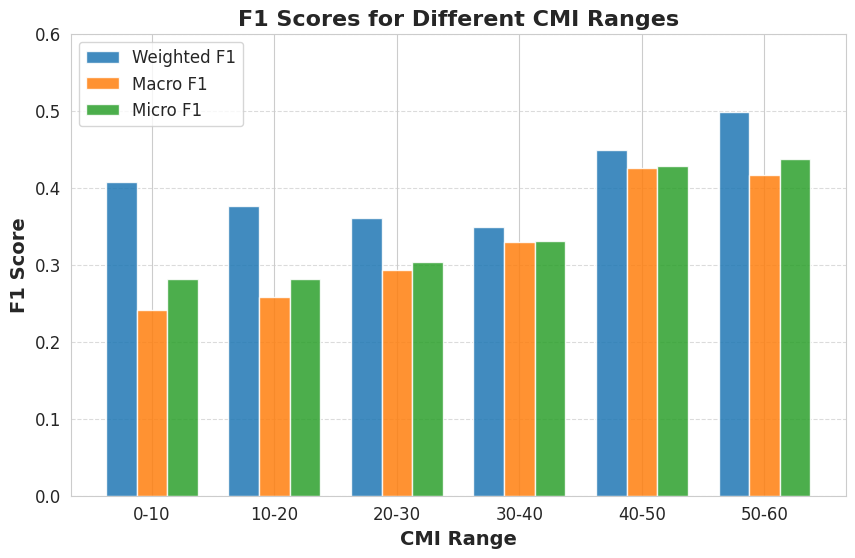

In [31]:
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

# Set theme
sns.set_style("whitegrid")

# CMI ranges
cmi_ranges = ["0-10", "10-20", "20-30", "30-40", "40-50", "50-60"]

# F1 scores
weighted_f1 = [0.4077, 0.3767, 0.3611, 0.3487, 0.4484, 0.4989]
macro_f1 = [0.2417, 0.2585, 0.2933, 0.3296, 0.4254, 0.4170]
micro_f1 = [0.2821, 0.2820, 0.3031, 0.3306, 0.4277, 0.4375]

# X-axis positions
x = np.arange(len(cmi_ranges))
bar_width = 0.25

# Create figure
plt.figure(figsize=(10, 6))

# Plot bars
plt.bar(x - bar_width, weighted_f1, width=bar_width, label="Weighted F1", color='#1f77b4', alpha=0.85)
plt.bar(x, macro_f1, width=bar_width, label="Macro F1", color='#ff7f0e', alpha=0.85)
plt.bar(x + bar_width, micro_f1, width=bar_width, label="Micro F1", color='#2ca02c', alpha=0.85)

# Labels and title
plt.xlabel("CMI Range", fontsize=14, fontweight='bold')
plt.ylabel("F1 Score", fontsize=14, fontweight='bold')
plt.title("F1 Scores for Different CMI Ranges", fontsize=16, fontweight='bold')
plt.xticks(x, cmi_ranges, fontsize=12)
plt.yticks(fontsize=12)
plt.ylim(0, 0.6)  # Adjust y-axis for better visibility
plt.legend(fontsize=12)

# Add grid lines
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Show plot
plt.show()


In [34]:
import pandas as pd

# Load the dataset
file_path = "/content/predictions_results30%.csv"
df = pd.read_csv(file_path)  # Use read_csv instead of read_excel

# Define CMI bins and labels
bins = [0, 10, 20, 30, 40, 50, 60]
bin_labels = ["0-10", "10-20", "20-30", "30-40", "40-50", "50-60"]
df['CMI_bin'] = pd.cut(df['CMI'], bins=bins, labels=bin_labels, right=False)

# Function to count words
def count_words(text):
    return len(str(text).split())

# Apply word count
df['word_count'] = df['Text'].apply(count_words)

# Calculate total words per CMI range
word_counts = df.groupby('CMI_bin')['word_count'].sum()

# Print results
for bin_label, count in word_counts.items():
    print(f"CMI Range {bin_label}: Total Words = {count}")


CMI Range 0-10: Total Words = 2536
CMI Range 10-20: Total Words = 10408
CMI Range 20-30: Total Words = 11379
CMI Range 30-40: Total Words = 4887
CMI Range 40-50: Total Words = 2722
CMI Range 50-60: Total Words = 1138


<ipython-input-34-528e3e760268>:20: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  word_counts = df.groupby('CMI_bin')['word_count'].sum()


In [35]:
import pandas as pd

# Load the dataset
file_path = "/content/predictions_results30%.csv"
df = pd.read_csv(file_path)  # Use read_csv instead of read_excel

# Define CMI bins and labels
bins = [0, 10, 20, 30, 40, 50, 60]
bin_labels = ["0-10", "10-20", "20-30", "30-40", "40-50", "50-60"]
df['CMI_bin'] = pd.cut(df['CMI'], bins=bins, labels=bin_labels, right=False)

# Count number of texts (rows) per CMI range
text_counts = df['CMI_bin'].value_counts().sort_index()

# Print results
for bin_label, count in text_counts.items():
    print(f"CMI Range {bin_label}: Number of Texts = {count}")


CMI Range 0-10: Number of Texts = 117
CMI Range 10-20: Number of Texts = 461
CMI Range 20-30: Number of Texts = 518
CMI Range 30-40: Number of Texts = 248
CMI Range 40-50: Number of Texts = 159
CMI Range 50-60: Number of Texts = 64
